# Setup

In [5]:
import torch
from PIL import Image
import numpy as np
import torch
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler, UNet2DModel
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionPipeline
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
)
device = torch.device('cuda')
cache_dir = "/data2/diffusion"

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", cache_dir=cache_dir).to(device)
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256", cache_dir=cache_dir)
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", cache_dir=cache_dir).to(device)

repo_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(repo_id, cache_dir=cache_dir)

ddpm = DDPMScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)
ddim = DDIMScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)
pndm = PNDMScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)
lms = LMSDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)
euler = EulerDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)
dpm = DPMSolverMultistepScheduler.from_pretrained(repo_id, subfolder="scheduler", cache_dir=cache_dir)

pipeline = StableDiffusionPipeline.from_pretrained(repo_id, scheduler=dpm, cache_dir=cache_dir).to(device)
pipeline = StableDiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.bfloat16, cache_dir=cache_dir).to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Diffusers
What if we want to use and modify the diffusion model? It is difficult to use diffusion models directly from the source code.

*Diffusers* enables easy use of diffusion models with minimal code

The key words are:
- **Library** for state-of-the art pretrained diffusion models
- **Generate** images, audio, and 3D structures
- **Modular** toolbox supporting simple inference and training


# DiffusionPipeline
DiffusionPipeline wraps the complexity of the entire diffusion system into an easy-to-use API, while remaining flexible enough to be adapted for other use cases, such as loading each component individually as building blocks to assemble your own diffusion system.

This section will show you how to:

- load *pipeline*s from the Hub
- write our own denoising process
- convert different components in the *pipeline*


## What is *pipeline*?



DiffusionPipeline provides a quick and easy way to run a model for inference, requiring no more than four lines of code to generate an image:

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

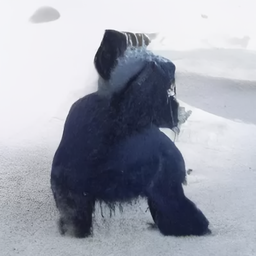

In [6]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", cache_dir=cache_dir).to(device)
image = ddpm(num_inference_steps=100).images[0]
image

<!-- <div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ddpm-cat.png" alt="Image of cat created from DDPMPipeline"/>
</div> -->

That was super easy, but how did the pipeline do that? Let's breakdown the pipeline and take a look at what's happening under the hood.

In [7]:
print(ddpm)

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "google/ddpm-cat-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}



In the example above, the pipeline contains a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel) model and a [DDPMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler).

Different models and schedulers can be used together.
*   Models contains weights. (e.g., Transformer2D, ControlNet)
*   Schedulers define how the denoising process is done. (e.g.,DDPM, DDIM)

<div class="flex justify-center">
    <img src="https://lh7-us.googleusercontent.com/A6VP2MAvy0H6cxFDQ8d8InjdYQ3WDdWM2tmEgc8FycGOyURU2a5Wzr0kuRwi0sxTl0nS5K9MQ4Frpqv68dQO3G5NeQmRKzEfKMbzb_vxFQEXjOJF6AHcnN7gpCvm8fYZhEvki3lzHiqrY7ieygXyWt8" width="400" />
</div>


The pipeline denoises an image by taking random noise the size of the desired output and passing it through the model several times. At each timestep, the model predicts the *noise residual* and the scheduler uses it to predict a less noisy image. The pipeline repeats this process until it reaches the end of the specified number of inference steps.

To recreate the above denoising process without the pipeline, you can declare the model and scheduler separately, as shown below:

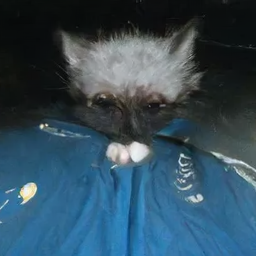

In [8]:
from diffusers import DDPMScheduler, UNet2DModel
from PIL import Image
import numpy as np
import torch

# Load the model and scheduler
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256", cache_dir=cache_dir)
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", cache_dir=cache_dir).to(device)


# Create some random noise with the same shape as the desired output
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to(device)

# Write a loop to iterate over the timesteps.
# At each timestep, the model does a UNet2DModel.forward() pass and returns the noisy residual.
# The scheduler's step() method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep.
# This output becomes the next input to the model
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

# convert the denoised output into an image
image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image



---


As a class method, [DiffusionPipeline.from_pretrained()](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline.from_pretrained) is responsible for two things:

- Download the latest version of the folder structure required for inference and cache it. If the latest folder structure is available in the local cache, [DiffusionPipeline.from_pretrained()](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline.from_pretrained) reuses the cache and won't redownload the files.
- Load the cached weights into the correct pipeline [class](https://huggingface.co/docs/diffusers/main/en/using-diffusers/./api/pipelines/overview#diffusers-summary) - retrieved from the `model_index.json` file - and return an instance of it.

The pipelines underlying folder structure corresponds directly with their class instances. For example, the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline) corresponds to the folder structure in [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5).

In [9]:
from diffusers import DiffusionPipeline

repo_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(repo_id, cache_dir=cache_dir)
print(pipeline)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



The above pipeline is an instance of [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline), which consists of seven components:

- `"feature_extractor"`: a [CLIPFeatureExtractor](https://huggingface.co/docs/transformers/main/en/model_doc/clip#transformers.CLIPFeatureExtractor) from 🤗 Transformers.
- `"safety_checker"`: a [component](https://github.com/huggingface/diffusers/blob/e55687e1e15407f60f32242027b7bb8170e58266/src/diffusers/pipelines/stable_diffusion/safety_checker.py#L32) for screening against harmful content.
- `"scheduler"`: an instance of [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm#diffusers.PNDMScheduler).
- `"text_encoder"`: a [CLIPTextModel](https://huggingface.co/docs/transformers/main/en/model_doc/clip#transformers.CLIPTextModel) from 🤗 Transformers.
- `"tokenizer"`: a [CLIPTokenizer](https://huggingface.co/docs/transformers/main/en/model_doc/clip#transformers.CLIPTokenizer) from 🤗 Transformers.
- `"unet"`: an instance of [UNet2DConditionModel](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d-cond#diffusers.UNet2DConditionModel).
- `"vae"` an instance of [AutoencoderKL](https://huggingface.co/docs/diffusers/main/en/api/models/autoencoderkl#diffusers.AutoencoderKL).


<div class="flex justify-center">
    <img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" width="400" />
</div>

Compare the components of the pipeline instance to the [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5) folder structure, and you'll see there is a separate folder for each of the components in the repository:

```
.
├── feature_extractor
│   └── preprocessor_config.json
├── model_index.json
├── safety_checker
│   ├── config.json
│   └── pytorch_model.bin
├── scheduler
│   └── scheduler_config.json
├── text_encoder
│   ├── config.json
│   └── pytorch_model.bin
├── tokenizer
│   ├── merges.txt
│   ├── special_tokens_map.json
│   ├── tokenizer_config.json
│   └── vocab.json
├── unet
│   ├── config.json
│   ├── diffusion_pytorch_model.bin
└── vae
    ├── config.json
    ├── diffusion_pytorch_model.bin
```


## Design a custom pipeline

### Schedulers

Diffusion pipelines are inherently a collection of diffusion models and schedulers that are partly independent from each other. This means that one is able to switch out parts of the pipeline to better customize a pipeline to one's use case. The best example of this is the [Schedulers](https://huggingface.co/docs/diffusers/main/en/using-diffusers/../api/schedulers/overview.mdx).

Whereas diffusion models usually simply define the forward pass from noise to a less noisy sample,
schedulers define the whole denoising process, *i.e.*:
- How many denoising steps?
- Stochastic or deterministic?
- What algorithm to use to find the denoised sample

They can be quite complex and often define a trade-off between **denoising speed** and **denoising quality**.
It is extremely difficult to measure quantitatively which scheduler works best for a given diffusion pipeline, so it is often recommended to simply try out which works best.

```python
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

# replace the pipelines scheduler with `DPMSolverMultistepScheduler`
repo_id = "runwayml/stable-diffusion-v1-5"
dpm = DPMSolverMultistepScheduler.from_pretrained(repo_id, subfolder="scheduler")
pipeline.scheduler = dpm

# You can take a look at all available, compatible schedulers for the pipeline as follows
pipeline.scheduler.compatibles

# You can set the number of timesteps to run the denoising process
image = pipeline(prompt, generator=generator, num_inference_steps=20).images[0]

```

### Accelerate inference

With PyTorch 2 alone, you can accelerate the inference latency of text-to-image diffusion pipelines by up to 3x. This section will show you how to progressively apply the optimizations found in PyTorch 2 to reduce inference latency.

**Reduced precision**

Enable the first optimization, reduced precision. There are several benefits of using reduced precision:



*   Using a reduced numerical precision (such as float16 or bfloat16) for inference doesn’t affect the generation quality but significantly improves latency.
*   The benefits of using bfloat16 compared to float16 are hardware dependent, but modern GPUs tend to favor bfloat16.
*   bfloat16 is much more resilient when used with quantization compared to float16, but more recent versions of the quantization library (torchao) we used don’t have numerical issues with float16.




```python
pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.bfloat16
).to(device)
```

**Combine the attention block’s projection matrices**

The UNet and VAE in SDXL use Transformer-like blocks which consists of attention blocks and feed-forward blocks.

In an attention block, the input is projected into three sub-spaces using three different projection matrices – Q, K, and V. These projections are performed separately on the input. But we can horizontally combine the projection matrices into a single matrix and perform the projection in one step. This increases the size of the matrix multiplications of the input projections and improves the impact of quantization.

You can combine the projection matrices with just a single line of code:

```python
pipe.fuse_qkv_projections()
```

### Let's try it out!
Let's customize the following pipeline.

Conditions:
*   Do not change the prompt
*   You can also modify components of the pipeline other than the scheduler.
*   Must be an instance of StableDiffusionPipeline.

Objectives:
*   Design a fast pipeline.
*   Design a high-quality pipeline.

In [13]:
prompt = "A photograph of an astronaut riding a horse on Mars, high resolution, high definition."

In [16]:
from diffusers import StableDiffusionPipeline

# ## example pipeline
# pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# generator = torch.Generator(device=device).manual_seed(8)

## example pipeline
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, cache_dir=cache_dir).to(device) # float16 // bfloat16 is not supported in colab env

## change pipeline scheduler (DPMSolverMultistepScheduler gives arguably the best speed/quality trade-off and can be run with as little as 20)
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config) ## high speed scheduler

# fuse projections
pipeline.fuse_qkv_projections()

generator = torch.Generator(device=device).manual_seed(8)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

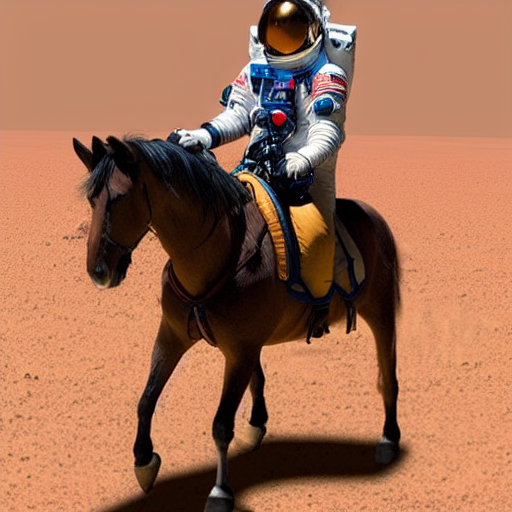

In [19]:
image = pipeline(prompt, generator=generator, num_inference_steps=20).images[0]

image

In [18]:
print(pipeline)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



incrementally applied
*   기본 pipeline latency : 23s
*   scheduler change (DPM) : 22s
*   reduce inference step (20) : 8s
*   float16 : 3s
*   fuse projection : 2s
